# Hands-on Deep Generative Models

**Authors:** M. Barbetti (INFN-CNAF), S. Capelli (INFN-MiB), F. Vaselli (INFN-Pisa)

**Date created:** 30/10/2023

**Last modified:** 31/10/2023

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/landerlini/mlinfn-advanced-hackathon/tutorial_gen_models.ipynb)
[![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/landerlini/mlinfn-advanced-hackathon/tutorial_gen_models.ipynb)
[![Open in GitHub](https://img.shields.io/badge/Open_in_GitHub-blue?style=flat&logo=github&logoColor=white&labelColor=555)](https://github.com/landerlini/mlinfn-advanced-hackathon/tutorial_gen_models.ipynb)

**Description:** This hands-on demonstrates how deep generative models succeed in reproducing the high-level response of a generic HEP experiment, offering a viable solution to reduce the pressure on the computing budget for simulation production. In particular, in this notebook we will test the performance of Generative Adversarial Networks and Normalizing Flows to parameterize the errors introduced during the detection and reconstruction of high-energy particle jets using the CMS detector.

## Introduction

### What is CMS?

TBA

#### Measuring jets at CMS

TBA

### What are Deep Generative Models?

#### Generative Adversarial Networks

Generative Adversarial Networks [[1](https://arxiv.org/abs/1406.2661)] are a powerful class of _generative models_ based on the simultaneous training of two neural networks:

*  **Discriminator network** ($D$) - trained by a classification task to separate the generator output from the reference dataset
* **Generator network** ($G$) - trained by a simulation task to reproduce the reference dataset trying to fake the discriminator

The goal is that $D$ optimally discriminates on the origin of the two samples, and simultaneously the training procedure for $G$ is to maximize the _probability_ of $D$ making a mistake. This framework corresponds to a **minimax two-player game** [[1](https://arxiv.org/abs/1406.2661)].

Traditional GAN systems suffer from many issues, particularly during the training phase:

* the generator may _collapse_ producing only a single sample or a small family of very similar samples (**mode collapse**)
* the two players may _oscillate_ during training rather than converging to the [**Nash equilibrium**](https://en.wikipedia.org/wiki/Nash_equilibrium)
* if _imbalance_ between the two players occurs, then the system is incapable of learning at all

All these drawbacks result from the [**vanishing gradient problem**](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), namely the lack of information for the update of the $G$ parameters. This is due to the saturation of the $D$ that is so good in distinguishing the origin of the two samples that no errors remain to the $G$ to improve the generated space [[2](https://arxiv.org/abs/1701.04862)]. To fix such problem, the typical solution proposed by the literature is to change the loss function that drive the training procedure [[3](https://arxiv.org/abs/1611.04076), [4](https://arxiv.org/abs/1701.07875)], to force the smoothness of the discriminator response to the classification task [[5](https://arxiv.org/abs/1704.00028), [6](https://arxiv.org/abs/1705.10743), [7](https://arxiv.org/abs/1907.05681)], or to adoopt a set of strategies in the architecture of the two players [[8](https://arxiv.org/abs/1606.03498)]. Each of these solutions can be easily implemented through [pidgan](https://github.com/mbarbetti/pidgan), a Python package designed to simplify the provisioning of GAN-based models to flash-simulate the LHCb experiment.

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/gan-scheme.png" width="800"/>
</div>

#### Normalizing Flows

TBA

## Hands-on generative models with CMS data

TBA (overview of the hands-on with some details on the physics aspects)

### Prerequisites

The first step is to import the main packages of this hands-on, namely [pidgan](https://github.com/mbarbetti/pidgan) and [pyro](https://pyro.ai). If you are running out of the provided ML-INFN instances (like Colab or Kaggle), before to run the following code cells, you need to install the both the packages and some other ones that are typically needed in machine learning applications to HEP (i.e., uproot, scipy, scikit-learn, matplotlib). This can be done adding a new code cell containing what follows:

```
%%capture
!pip install pidgan[hep] pyro
```

Let's verify the correct installation of [pidgan](https://github.com/mbarbetti/pidgan) printing its version:

In [1]:
import pidgan

pidgan.__version__

'0.0.6'

Since [pidgan](https://github.com/mbarbetti/pidgan) relies on TensorFlow and Keras as backends, we also need to verify the correct installation of TensorFlow checking that it is able to assess and run on the equipped GPU (if any):

In [2]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")  # outputs a non-empty list in case of GPU equipped

2023-10-31 14:53:46.162133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 14:53:46.939300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]

Now, let's verify the correct installation of [pyro](https://pyro.ai) printing its version:

In [3]:
# import pyro
#
# pyro.__version__

Since [pyro](https://pyro.ai) relies on PyTroch as backend, we also need to verify the correct installation of PyTorch checking that it is able to assess and run on the equipped GPU (if any):

In [4]:
# import torch
#
# TBA (add PyTorch test similar to the TF one)

Finally, we just have to import all the modules that we will use in the following code cells:

In [5]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, StandardScaler, LabelEncoder, OneHotEncoder

### Data loading

The data needed for this hands-on is provided within the `data` folder as a root file (`'cms_data.root'`). The dataset contains about 1.2M instances, 6 input features and 4 output features. Let's import the data as a pandas [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html):

In [6]:
with uproot.open("./data/cms_data.root") as file:
  data = file["recojet"].arrays(library="pd").drop("index", axis=1)

data.describe()

,pT,theta,phi,E,b_tag,flavour,reco_pT,reco_theta,reco_phi,reco_nConstituents
count,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06
mean,5.774316e+01,-3.606635e-03,3.142674e+00,1.820326e+02,3.891182e-01,-1.751057e-03,5.823546e+01,-3.583049e-03,3.142717e+00,1.772764e+01
std,4.740463e+01,1.698428e+00,1.813134e+00,2.612149e+02,3.799157e-01,2.957189e+00,4.954559e+01,1.698818e+00,1.813508e+00,8.978564e+00
min,1.500001e+01,-6.247127e+00,1.370349e-06,1.511571e+01,3.145769e-05,-5.000000e+00,-2.736475e+00,-6.225502e+00,1.377906e-06,0.000000e+00
25%,2.606500e+01,-1.156958e+00,1.575168e+00,5.171500e+01,5.980294e-02,0.000000e+00,2.604108e+01,-1.156651e+00,1.574912e+00,1.100000e+01
50%,4.404862e+01,-4.191196e-03,3.141528e+00,9.736305e+01,1.744231e-01,0.000000e+00,4.390334e+01,-4.189691e-03,3.141232e+00,1.600000e+01
75%,7.374522e+01,1.150521e+00,4.711539e+00,1.969485e+02,8.527536e-01,0.000000e+00,7.428231e+01,1.150217e+00,4.712032e+00,2.300000e+01
max,1.568434e+03,6.298655e+00,6.283185e+00,5.069652e+03,9.999949e-01,5.000000e+00,1.915857e+03,6.525997e+00,6.533353e+00,1.100000e+02


**Note:** If you are running out of the provided ML-INFN instances (like Colab or Kaggle), a reduced version of the original dataset is available through a CSV file and can be imported as a pandas [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) using the following code lines:

```python
url = "https://raw.githubusercontent.com/landerlini/mlinfn-advanced-hackathon/main/generative_models/data/cms_data_reduced.csv"
data = pd.read_csv(url)
```

TBA (add some information about the input features)

Gen-level info:
* `data.pT` - transverse momentum in GeV/$c$ of the jet
* `data.theta` - angle of the jet direction in the z-y plane
* `data.phi` - angle of the jet direction in the x-y plane
* `data.E` - total energy in GeV of the jet
* `data.b_tag` - TBA (add description)
* `data.flavour` - TBA (add description)

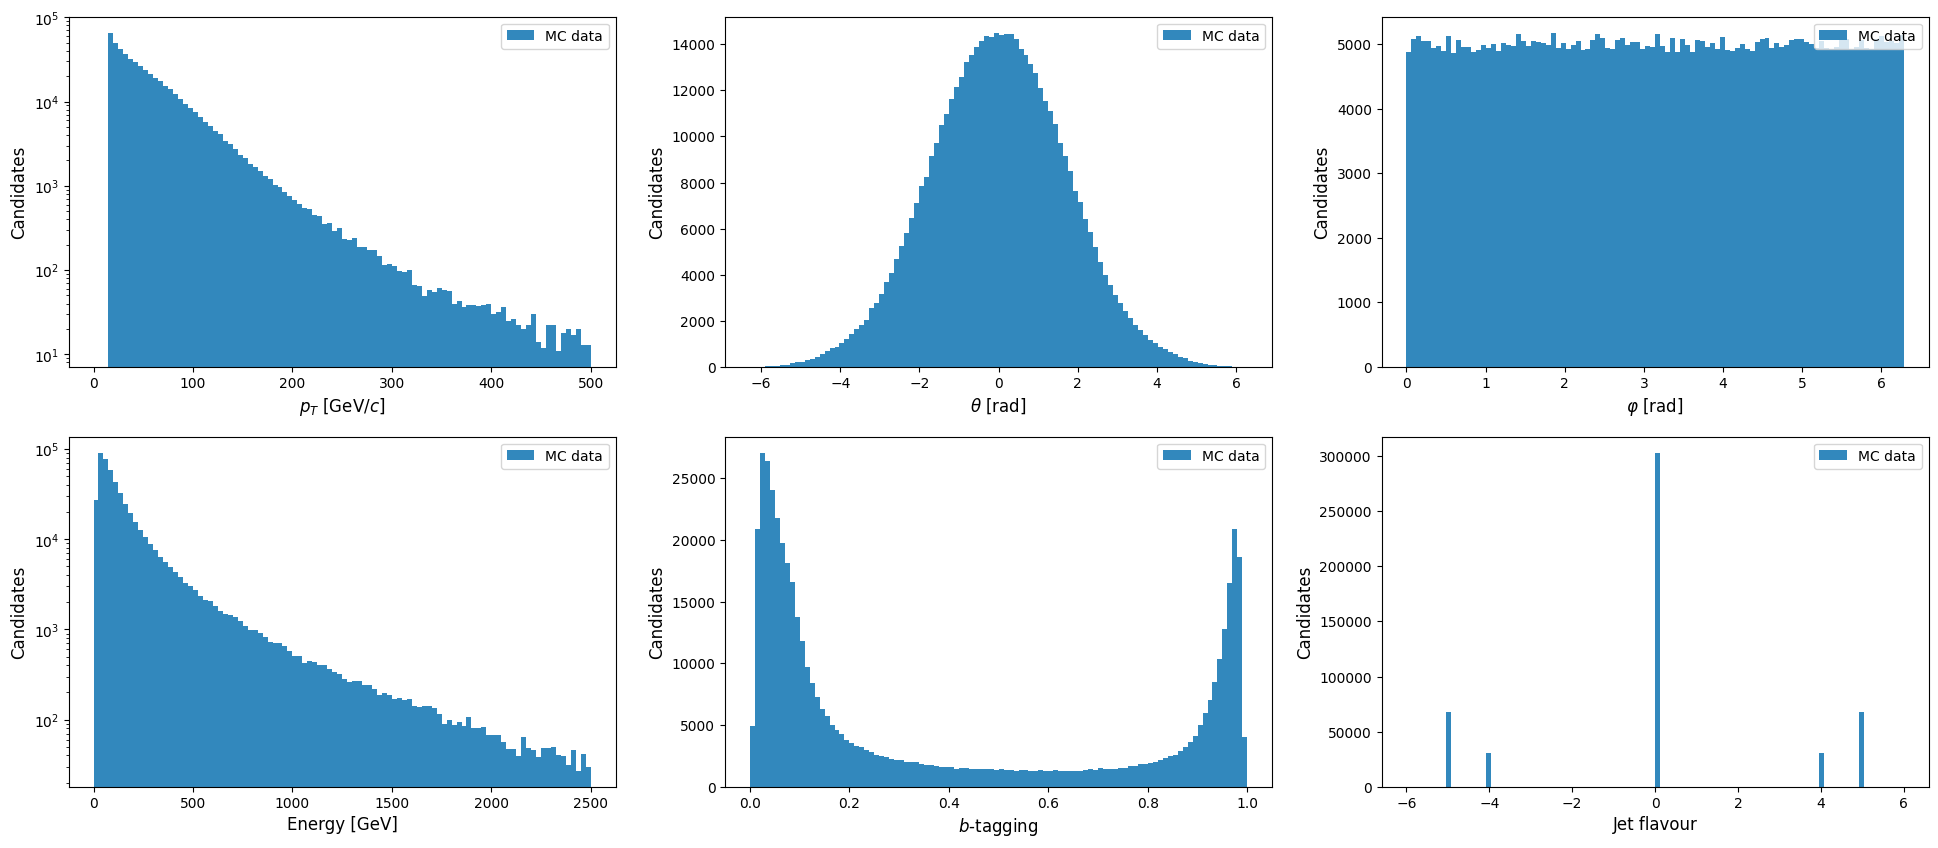

In [40]:
plt.figure(figsize=(24, 10))

plt.subplot(2, 3, 1)
plt.xlabel("$p_T$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["pT"], bins=np.linspace(0.0, 500.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 3, 2)
plt.xlabel(r"$\theta$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["theta"], bins=np.linspace(-2*np.pi, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 3)
plt.xlabel(r"$\varphi$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["phi"], bins=np.linspace(0.0, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 4)
plt.xlabel("Energy [GeV]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["E"], bins=np.linspace(0.0, 2500.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 3, 5)
plt.xlabel("$b$-tagging", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["b_tag"], bins=np.linspace(0.0, 1.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 6)
plt.xlabel("Jet flavour", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["flavour"], bins=np.linspace(-6.0, 6.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.show()

TBA (add some information about the output features)

Reco-level info:
* `data.reco_pT` - reconstructed transverse momentum in GeV/$c$ of the jet
* `data.reco_theta` - reconstructed angle of the jet direction in the z-y plane
* `data.reco_phi` - reconstructed angle of the jet direction in the x-y plane
* `data.reco_nConstituents` - TBA (add description)

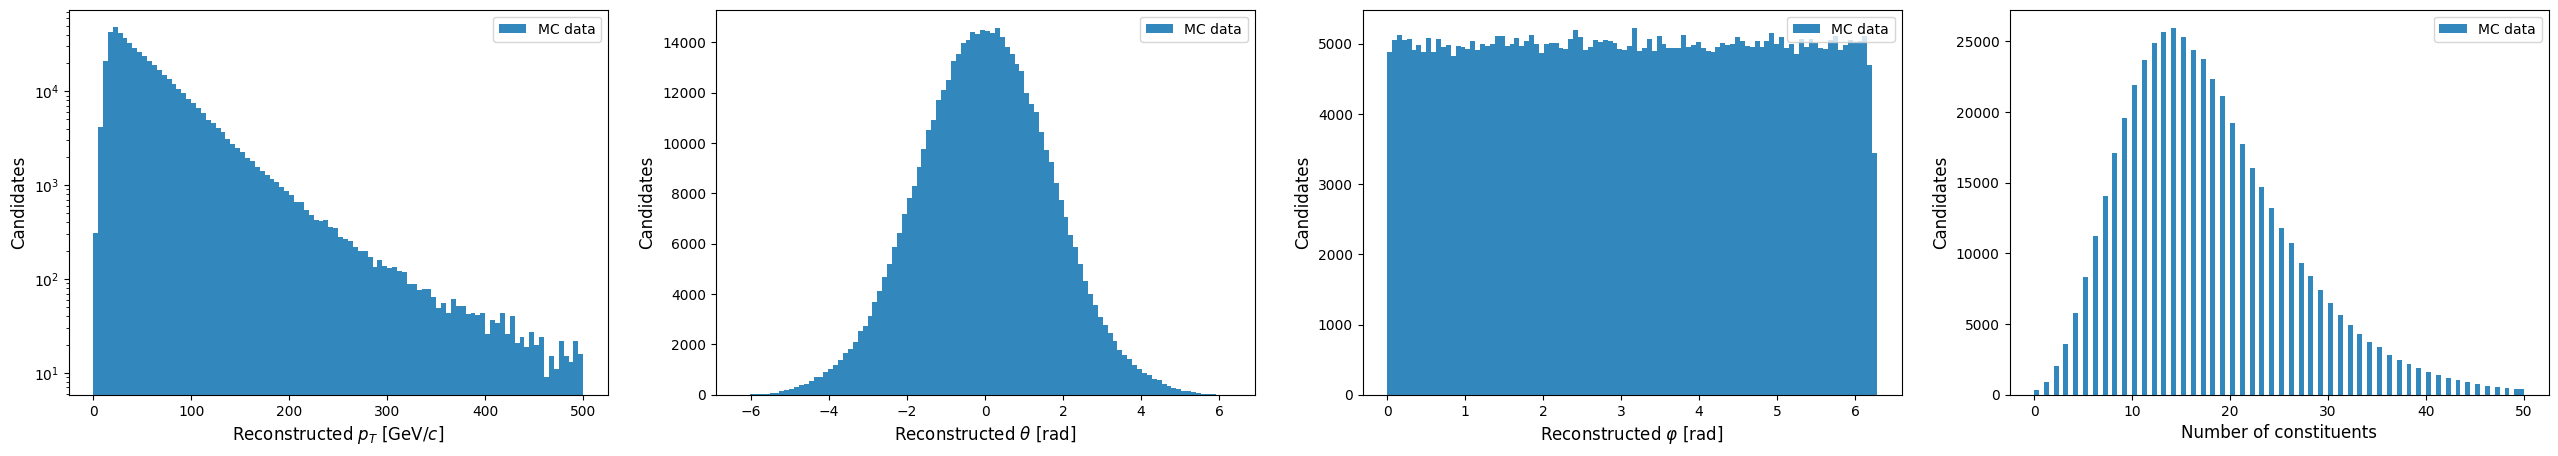

In [41]:
plt.figure(figsize=(32, 5))

plt.subplot(1, 4, 1)
plt.xlabel("Reconstructed $p_T$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_pT"], bins=np.linspace(0.0, 500.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(1, 4, 2)
plt.xlabel(r"Reconstructed $\theta$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_theta"], bins=np.linspace(-2*np.pi, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 4, 3)
plt.xlabel(r"Reconstructed $\varphi$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_phi"], bins=np.linspace(0.0, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 4, 4)
plt.xlabel("Number of constituents", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_nConstituents"], bins=np.linspace(0.0, 50.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.show()

### Data preprocessing

As usual in a machine learning application, the data sample is split into **training** and **test set**.

In [9]:
data = shuffle(data)

chunk_size = 500000  # -1 for the whole dataset
data = data[:chunk_size]

x_vars = ["pT", "theta", "phi", "E", "b_tag", "flavour"]
x = data[x_vars].values

y_vars = ["reco_pT", "reco_theta", "reco_phi", "reco_nConstituents"]
y = data[y_vars].values

train_ratio = 0.7
train_size = int(train_ratio * len(data))

x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"x_train shape: {x_train.shape} \t x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape} \t y_test shape: {y_test.shape}")

x_train shape: (350000, 6) 	 x_test shape: (150000, 6)
y_train shape: (350000, 4) 	 y_test shape: (150000, 4)


To normalize the different ranges and orders of magnitude of input $x$ and output $y$ features highlighted by the previous histograms, we will use the scikit-learn [`QuantileTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) and [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) preprocessing operators.

Since one of the $x$ features is categorical (`data.flavour`), the latter should be kept unchanged by the preprocessing operators and transformed through a [**one-hot**](https://en.wikipedia.org/wiki/One-hot) encoder.

If we want to combine together different preprocessing operators in one go, we can use the [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) class by scikit-learn.

In [10]:
x_scaler = ColumnTransformer(
  [
    ("quantile", QuantileTransformer(output_distribution="normal"), (0, 3, 4)),  # pT, E, b_tag
    ("standard", StandardScaler(), (1, 2)),  # theta, phi
  ]
)
x_train_prep = x_scaler.fit_transform(x_train[:, :-1])  # except 'flavour' column

pd.DataFrame(x_train_prep, columns=["pT", "E", "b_tag", "theta", "phi"]).describe()

,pT,E,b_tag,theta,phi
count,350000.000000,350000.000000,350000.000000,3.500000e+05,3.500000e+05
mean,0.016735,-0.023120,-0.013810,-7.349042e-18,-1.888014e-17
std,1.001271,1.000762,1.006321,1.000001e+00,1.000001e+00
min,-5.199338,-5.199338,-5.199338,-3.676578e+00,-1.732585e+00
25%,-0.654883,-0.697961,-0.686036,-6.792248e-01,-8.646212e-01
50%,0.020403,-0.015137,-0.033155,-3.167640e-04,1.690616e-04
75%,0.684616,0.657328,0.663090,6.799768e-01,8.669741e-01
max,5.199338,5.199338,5.199338,3.697862e+00,1.729498e+00


In [11]:
label_encoder = LabelEncoder()
int_encoded = label_encoder.fit_transform(x_train[:, 5])

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(int_encoded[:, None])  # one-hot encoding

x_train_prep = np.concatenate([x_train_prep, onehot_encoded], axis=1)
x_train_prep.shape

(350000, 10)

Since most of the output $y$ features are the reconstructed version of the input $x$ features, we should build a model able to reproduce only the **errors** introduced in the detection and reconstruction steps instead of directly parameterize the reconstruction algorithms. This _regularizes_ the training procedure and may simplify any debugging campaign.

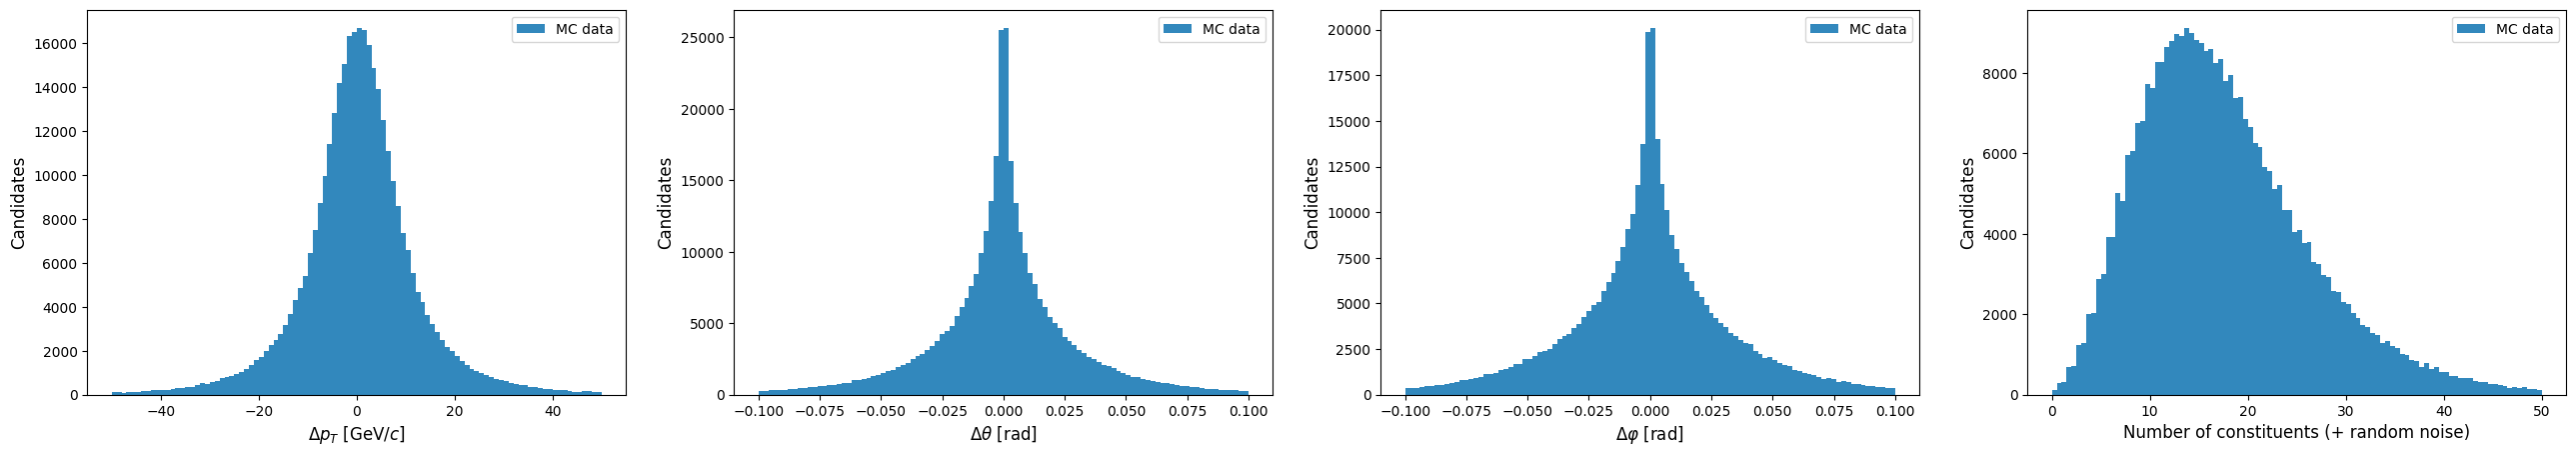

In [12]:
y_train_prep = y_train.copy()
y_train_prep[:, :3] -= x_train[:, :3]
y_train_prep[:, -1] += np.random.normal(0.0, 0.2, size=(len(y_train),))  # from discrete to continous

plt.figure(figsize=(32, 5))

plt.subplot(1, 4, 1)
plt.xlabel("$\Delta p_T$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_train_prep[:, 0], bins=np.linspace(-50.0, 50.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 4, 2)
plt.xlabel(r"$\Delta \theta$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_train_prep[:, 1], bins=np.linspace(-0.1, 0.1, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 4, 3)
plt.xlabel(r"$\Delta \varphi$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_train_prep[:, 2], bins=np.linspace(-0.1, 0.1, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 4, 4)
plt.xlabel("Number of constituents (+ random noise)", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_train_prep[:, 3], bins=np.linspace(0.0, 50.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.show()

In [14]:
y_scaler = QuantileTransformer(output_distribution="normal")
y_train_prep = y_scaler.fit_transform(y_train_prep)

pd.DataFrame(y_train_prep, columns=y_vars).describe()

,reco_pT,reco_theta,reco_phi,reco_nConstituents
count,350000.000000,350000.000000,350000.000000,350000.000000
mean,-0.012496,0.009561,0.006110,-0.003023
std,0.994103,1.000585,0.999213,1.009437
min,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.685141,-0.651791,-0.669887,-0.680394
50%,-0.018777,0.017516,0.010428,0.005380
75%,0.668086,0.671967,0.677806,0.669041
max,5.199338,5.199338,5.199338,5.199338


### Generative Adversarial Networks

Implementing a GAN in TensorFlow is straightforward, even if becoming familiar with the various tricks to stabilize the training procedure or moving from a GAN flavour to another may be non-trivial. The aim of this hands-on is to prove the effectiveness of generative models for HEP simulations, hence we will rely on [pidgan](https://github.com/mbarbetti/pidgan) for the GAN implementations. Such Python package has been designed in the context of LHCb flash-simulation and offers a wide set of GAN algorithms implemented customizing the TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class.

| Algorithms* | Lipschitzianity** | Design inspired by | Tutorial |
|:-----------:|:-----------------:|:------------------:|:--------:|
| [`GAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/GAN.py) | ❌ | [1](https://arxiv.org/abs/1406.2661), [2](https://arxiv.org/abs/1701.04862), [8](https://arxiv.org/abs/1606.03498) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-GAN-LHCb_RICH.ipynb) |
| [`BceGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN.py) | ❌ | [1](https://arxiv.org/abs/1406.2661), [2](https://arxiv.org/abs/1701.04862), [8](https://arxiv.org/abs/1606.03498) | 🛠️ |
| [`BceGAN_GP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN_GP.py) | ✅ | [1](https://arxiv.org/abs/1406.2661), [5](https://arxiv.org/abs/1704.00028), [8](https://arxiv.org/abs/1606.03498) | 🛠️ |
| [`BceGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN_ALP.py) | ✅ | [1](https://arxiv.org/abs/1406.2661), [7](https://arxiv.org/abs/1907.05681), [8](https://arxiv.org/abs/1606.03498) | 🛠️ |
| [`LSGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/LSGAN.py) | ❌ | [3](https://arxiv.org/abs/1611.04076), [2](https://arxiv.org/abs/1701.04862), [8](https://arxiv.org/abs/1606.03498) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-LSGAN-LHCb_RICH.ipynb) |
| [`WGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN.py) | ✅ | [4](https://arxiv.org/abs/1701.07875), [8](https://arxiv.org/abs/1606.03498) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-WGAN-LHCb_RICH.ipynb) |
| [`WGAN_GP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN_GP.py) | ✅ | [5](https://arxiv.org/abs/1704.00028), [8](https://arxiv.org/abs/1606.03498) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-WGAN_GP-LHCb_RICH.ipynb) |
| [`CramerGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/CramerGAN.py) | ✅ | [6](https://arxiv.org/abs/1705.10743), [8](https://arxiv.org/abs/1606.03498) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-CramerGAN-LHCb_RICH.ipynb) |
| [`WGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN_ALP.py) | ✅ | [7](https://arxiv.org/abs/1907.05681), [8](https://arxiv.org/abs/1606.03498) |  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-WGAN_ALP-LHCb_RICH.ipynb) |

*each GAN algorithm is designed to operate taking __conditions__ as input [[9](https://arxiv.org/abs/1411.1784)]

**the GAN training is regularized to ensure that the discriminator encodes a 1-Lipschitz function

Training a GAN system corresponds to perform a competition, namely the **minimax game**, between the generator and discriminator networks. The latters are provided by the [pidgan](https://github.com/mbarbetti/pidgan) package through the [`players`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/players) module that implements the two networks via custom TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)s.

#### The generator

The **generator player** can be implemented with the high-level [`Generator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/generators/Generator.py) class that provides the neural network model wrapping the TensorFlow [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). Before to initialize a `Generator` instance, let's have a look at its arguments:

* **`output_dim`** (_int_) - Dimensionality of the generator output space.
* **`latent_dim`** (_int_) - Dimensionality of the latent space.
* **`num_hidden_layers`** (_int_, default=5) - Number of the hidden layers passed to the [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model. Each hidden layer has a LeakyReLU as activation function (see [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU)).
* **`mlp_hidden_units`** (_int_ or _array_like_, default=128) - Number of neuron units per each hidden layer. It can also be passed as an array of unit numbers having length equal to the number of hidden layers.
* **`mlp_dropout_rates`** (_float_ or _array_like_, default=0.0) - Fraction of the input neurons to drop per each hidden layer. It can also be passed as an array of float numbers having length equal to the number of hidden layers.
* **`output_activation`** (_activation_like_ or _None_, default=None) - Activation function to use in the generator output layer (see [`tf.keras.activations`](https://www.tensorflow.org/api_docs/python/tf/keras/activations)). If None, no activation is applied (i.e., "linear" activation: $a(x) = x$).
* **`name`** (_str_ of _None_, default=None) - The name of the generator model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the generator layer computations and weights.

In [15]:
from pidgan.players.generators import Generator

generator = Generator(
    output_dim=y_train_prep.shape[-1],
    latent_dim=64,
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    output_activation=None,
    name="generator"
)

In [16]:
_ = generator(keras.Input(shape=x_train_prep.shape[1:]))
generator.summary()

Model: "generator_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 128)               9600      
                                                                 
 leaky_relu_0 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_0 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)             

#### The discriminator

The **discriminator player** can be implemented with the high-level [`Discriminator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/discriminators/Discriminator.py) class that provides the neural network model wrapping the TensorFlow [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). Again, before to initialize a `Discriminator` instance, let's have a look to its arguments:

* **`output_dim`** (_int_) - Dimensionality of the discriminator output space.
* **`num_hidden_layers`** (_int_, default=5) - Number of the hidden layers passed to the [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model. Each hidden layer has a LeakyReLU as activation function (see [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU)).
* **`mlp_hidden_units`** (_int_ or _array_like_, default=128) - Number of neuron units per each hidden layer. It can also be passed as an array of unit numbers having length equal to the number of hidden layers.
* **`mlp_dropout_rates`** (_float_ or _array_like_, default=0.0) - Fraction of the input neurons to drop per each hidden layer. It can also be passed as an array of float numbers having length equal to the number of hidden layers.
* **`output_activation`** (_activation_like_ or _None_, default="sigmoid") - Activation function to use in the dicriminator output layer (see [`tf.keras.activations`](https://www.tensorflow.org/api_docs/python/tf/keras/activations)). If None, no activation is applied (i.e., "linear" activation: $a(x) = x$).
* **`name`** (_str_ of _None_, default=None) - The name of the discriminator model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the discriminator layer computations and weights.

In [17]:
from pidgan.players.discriminators import Discriminator

discriminator = Discriminator(
    output_dim=1,
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    output_activation=None,
    name="discriminator"
)

In [18]:
_ = discriminator((keras.Input(shape=x_train_prep.shape[1:]), keras.Input(shape=y_train_prep.shape[1:])))
discriminator.summary()

Model: "discriminator_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 128)               1920      
                                                                 
 leaky_relu_0 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_0 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)         

#### The GAN algorithm

TBA (fix the following description)

The **WGAN-ALP algorithm** [[3](https://arxiv.org/abs/1701.07875)] can be implemented with the high-level [`WGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN_ALP.py) class that defines the training procedure of the two players customizing the TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class and, in particular, its `fit()` method. Once again, before to initialize a `WGAN_ALP` instance, let's have a look at its arguments:

* **`generator`** (_generator_like_) - The generator network. It must be passed as a pidgan [`Generator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/generators/Generator.py) instance.
* **`discriminator`** (_discriminator_like_) - The discriminator network. It must be passed as a pidgan [`Discriminator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/discriminators/Discriminator.py) instance.
* **`lipschitz_penalty`** (_float_, default=1.0) - Importance of the regularization term ALP that explicitly constrains the discriminator to induce a 1-Lipschitz function as proposed in Ref. [[4](https://arxiv.org/abs/1907.05681)].
* **`lipschitz_penalty_strategy`** (_str_, default="one-sided") - If "two-sided" is passed, the Lipschitz constant computed along the virtual adversarial direction is forced to be equal to 1. When "one-sided" is preferred, only Lipschitz constant values greater than 1 are penalized.
* **`feature_matching_penalty`** (_float_, default=0.0) - Importance of the regularization term added to the generator training to force the hidden state of the discriminator to match between reference and generated examples. Its design follows from what proposed in Ref. [[8](https://arxiv.org/abs/1606.03498)].
* **`referee`** (_classifier_like_ or _None_, default=None) - When passed it enables the training of a third independent player: the referee network. It can be used to assess the quality of the generator output during the training. If passed, it must be a pidgan [`Classifier`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/classifiers/Classifier.py) instance.
* **`name`** (_str_ or _None_, default=None) - The name of the WGAN-ALP model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the WGAN-ALP model computations.

To not further complicate this tutorial, we avoid to use the referee network in this case, even if its initialization is straightforward:

```python
from pidgan.players.classifiers import Classifier

referee = Classifier(
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    name="referee"
)
```

It's time to initialize a [`WGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN_ALP.py) instance!

In [19]:
from pidgan.algorithms import BceGAN_ALP

gan = BceGAN_ALP(
    generator=generator,
    discriminator=discriminator,
    lipschitz_penalty=1.0,
    lipschitz_penalty_strategy="one-sided",
    feature_matching_penalty=0.0,
    referee=None,
    name="BceGAN_ALP",
)

#### Training procedure

TBA (fix the following text)

To finalize the [`WGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN_ALP.py) model preparation before to run the training procedure, we need to execute the `compile()` method. Differently from the TensorFlow `compile()` method, the [pidgan](https://github.com/mbarbetti/pidgan) one doesn't require to pass the loss function since it is encoded in the customized `gan.fit()` method. The arguments of the `gan.compile()` method follows:

* **`metrics`** (_list_ or _None_, default=None) - If not None, list of metrics to be evaluated by the WGAN-ALP model during training and testing. Each of this can be a string (name of a built-in pidgan function) or a [`pidgan.metrics`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/metrics) instance.
* **`generator_optimizer`** (_optimizer_like_, default="rmsprop") - String (name of optimizer) or optimizer instance for the generator network (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`discriminator_optimizer`** (_optimizer_like_, default="rmsprop") - String (name of optimizer) or optimizer instance for the discriminator network. (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`generator_upds_per_batch`** (_int_, default=1) - Number of the generator weights updates per batch of data.
* **`discriminator_upds_per_batch`** (_int_, default=1) - Number of the discriminator weights updates per batch of data.
* **`virtual_adv_direction_upds`** (_int_, default=1) - Number of iterations to approximate the virtual adversarial direction per discriminator update.
* **`referee_optimizer`** (_optimizer_like_ or _None_, default=None) - If not None, string (name of optimizer) or optimizer instance for the referee network (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`referee_upds_per_batch`** (_int_ or _None_, default=None) - If not None, number of the referee weights updates per batch of data.

In [20]:
gan.compile(
    metrics=["wass_dist"],
    generator_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    discriminator_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    generator_upds_per_batch=1,
    discriminator_upds_per_batch=1,
    virtual_adv_direction_upds=1,
    referee_optimizer=None,
    referee_upds_per_batch=None,
)

The [pidgan](https://github.com/mbarbetti/pidgan) package provides several learning rate scheduling strategies through the [`callbacks.schedulers`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/callbacks/schedulers) module. The pidgan schedulers are designed as [custom TensorFlow callbacks](https://www.tensorflow.org/guide/keras/writing_your_own_callbacks) that also allow to trace the learning rate value of each passed optimizer during the training. In this tutorial, we will use an exponential decay schedule both for the generator and discriminator networks:

<center>$\eta(t) = \eta_0 \cdot e^{- \alpha \cdot t / \tau}$</center>

where $\eta(t)$ indicates the learning rate value at a specific training step $t$, $\eta_0$ the initial learning rate, $\alpha$ the decay rate and $\tau$ the decay step.

In [21]:
from pidgan.callbacks.schedulers import LearnRateExpDecay

schedules = list()

g_lr_sched = LearnRateExpDecay(
    gan.generator_optimizer,
    decay_rate=0.1,
    decay_steps=75000,
    min_learning_rate=1e-6,
    verbose=True,
    key="g_lr",
)
schedules.append(g_lr_sched)

d_lr_sched = LearnRateExpDecay(
    gan.discriminator_optimizer,
    decay_rate=0.1,
    decay_steps=50000,
    min_learning_rate=1e-6,
    verbose=True,
    key="d_lr",
)
schedules.append(d_lr_sched)

Calling `gan.fit()` allows to perform the **minimax two-player game**, training the generator to reproduce the reference space $y$ on the basis of the conditions $x$ thanks to the discriminator feedbacks. The arguments taken by the pidgan `fit()` method are the same ones traditionally passed to a TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) instance. The schedulers are passed through the `callbacks` argument and, since their verbosity has been enabled (`verbose` and `key` passed), the learning rates of both the generator and discriminator are printed during the training procedure.

In [22]:
start = datetime.now()

train = gan.fit(
    x=x_train_prep,
    y=y_train_prep,
    batch_size=256,
    epochs=100,
    validation_split=0.3,
    callbacks=schedules,
    verbose=0,
)

stop = datetime.now()

print(f"Training procedure completed in {stop - start}")

Training procedure completed in 0:17:10.191229


The following code cells report the **learning** and **metric curves** for the training just finished.

#### Learning curves

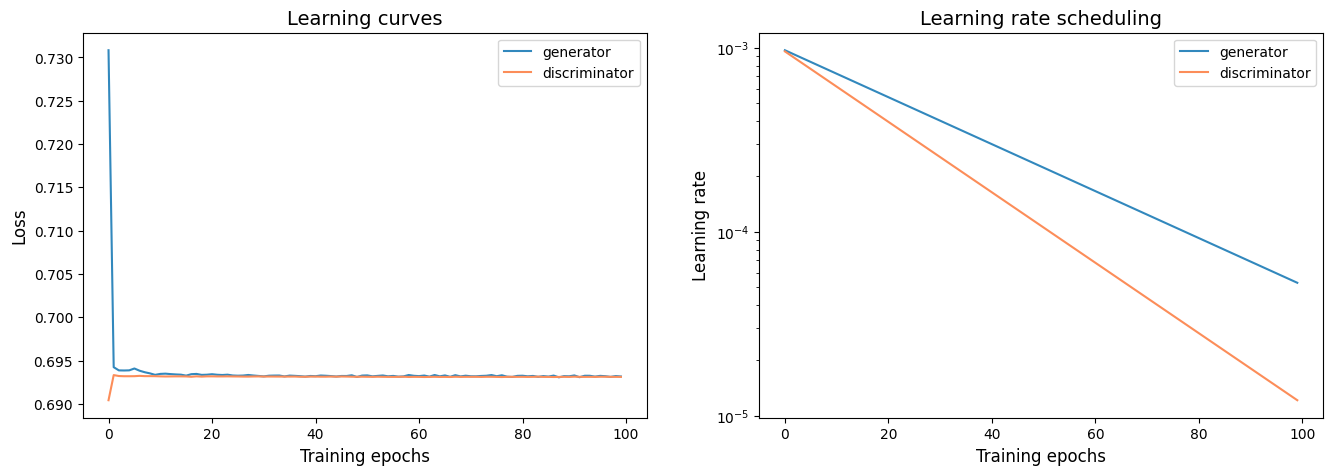

In [23]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.plot(train.history["g_loss"], color="#3288bd", label="generator")
plt.plot(train.history["d_loss"], color="#fc8d59", label="discriminator")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Learning rate scheduling", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Learning rate", fontsize=12)
plt.plot(train.history["g_lr"], color="#3288bd", label="generator")
plt.plot(train.history["d_lr"], color="#fc8d59", label="discriminator")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.show()

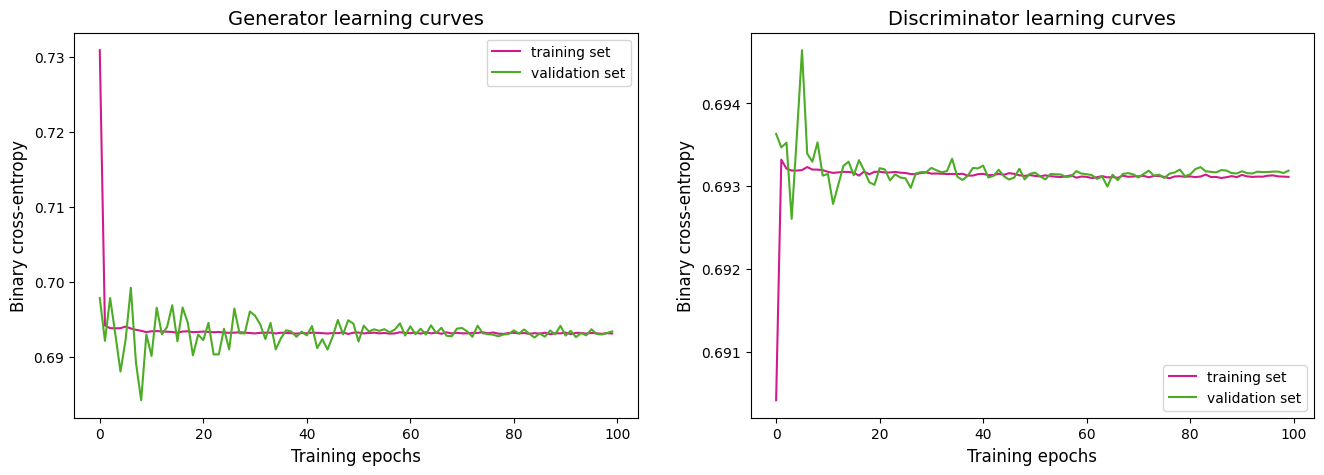

In [24]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Generator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["g_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_g_loss"], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Discriminator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["d_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_d_loss"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

#### Metric curves

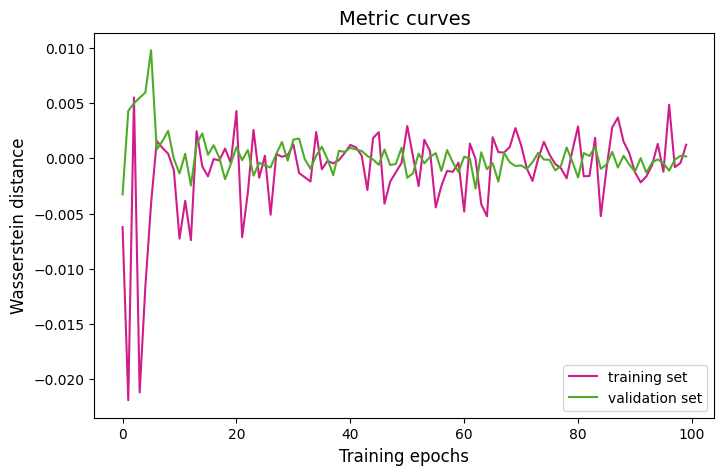

In [25]:
plt.figure(figsize=(8, 5), dpi=100)

plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Wasserstein distance", fontsize=12)
plt.plot(train.history["wass_dist"], color="#d01c8b", label="training set")
plt.plot(train.history["val_wass_dist"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

### Normalizing Flows

TBA

In [26]:
# TBA

### Validation plots

TBA (add description)

In [27]:
x_test_prep = x_scaler.transform(x_test[:, :-1])  # input pre-processing

int_encoded = label_encoder.transform(x_test[:, -1])
onehot_encoded = onehot_encoder.transform(int_encoded[:, None])  # one-hot encoding

x_test_prep = np.concatenate([x_test_prep, onehot_encoded], axis=1)

In [28]:
gan_out_test_prep = gan.generate(x_test_prep, seed=None).numpy()
gan_out_test_post = y_scaler.inverse_transform(gan_out_test_prep)  # output post-processing

gan_out_test = gan_out_test_post.copy()
gan_out_test[:, :3] += x_test[:, :3]
gan_out_test[:, -1] = np.round(gan_out_test[:, -1])

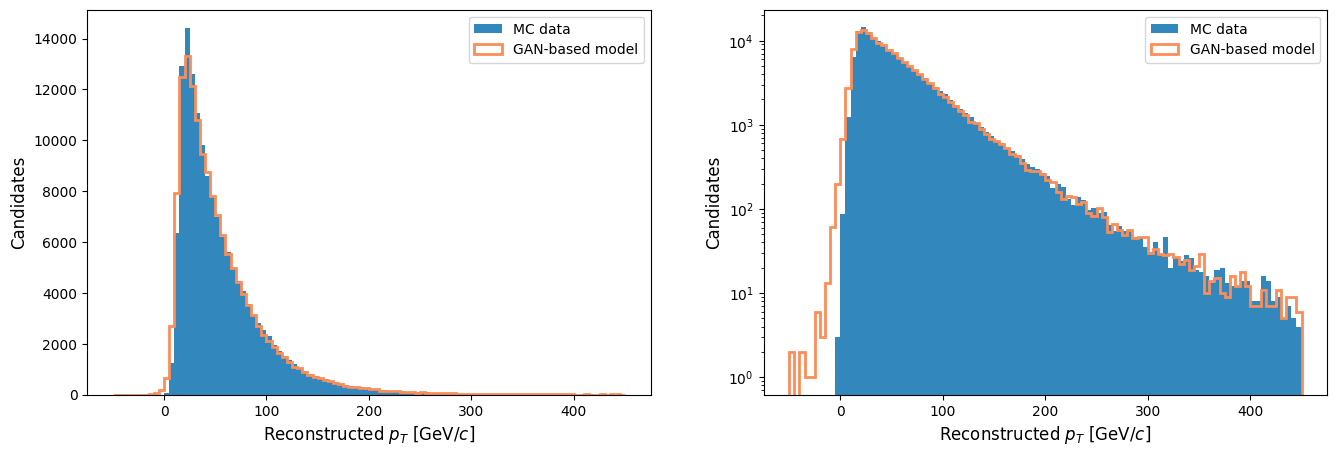

In [38]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(-50.0, 450.0, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("Reconstructed $p_T$ [GeV/$c$]", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 0], bins=bins, color="#3288bd", label="MC data")
    plt.hist(gan_out_test[:, 0], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN-based model")
    plt.legend(loc="upper right", fontsize=10)
    plt.yscale(scale)

plt.show()

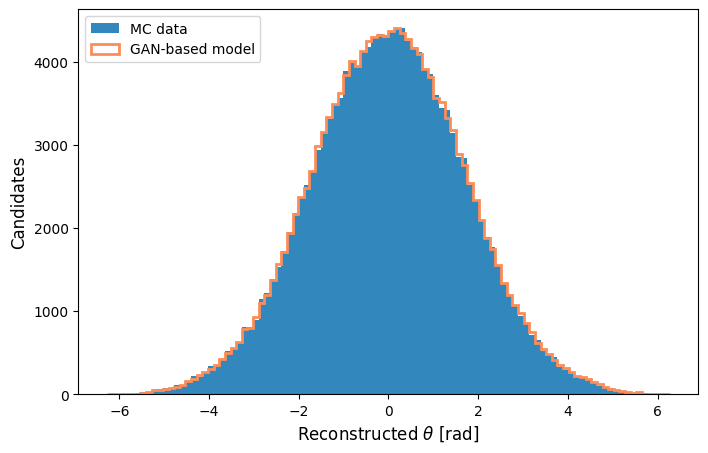

In [35]:
plt.figure(figsize=(8, 5), dpi=100)

bins = np.linspace(-2*np.pi, 2*np.pi, 101)

plt.xlabel(r"Reconstructed $\theta$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_test[:, 1], bins=bins, color="#3288bd", label="MC data")
plt.hist(gan_out_test[:, 1], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN-based model")
plt.legend(loc="upper left", fontsize=10)

plt.show()

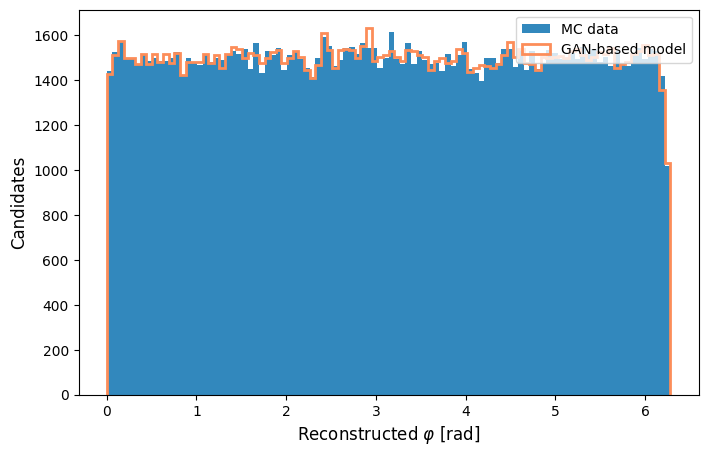

In [36]:
plt.figure(figsize=(8, 5), dpi=100)

bins = np.linspace(0.0, 2*np.pi, 101)

plt.xlabel(r"Reconstructed $\varphi$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_test[:, 2], bins=bins, color="#3288bd", label="MC data")
plt.hist(gan_out_test[:, 2], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN-based model")
plt.legend(loc="upper right", fontsize=10)

plt.show()

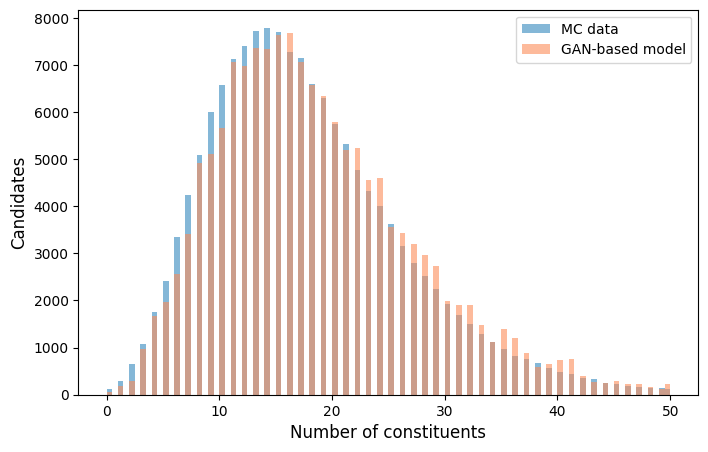

In [37]:
plt.figure(figsize=(8, 5), dpi=100)

bins = np.linspace(0.0, 50.0, 101)

plt.xlabel("Number of constituents", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_test[:, 3], bins=bins, color="#3288bd", alpha=0.6, label="MC data")
plt.hist(gan_out_test[:, 3], bins=bins, color="#fc8d59", alpha=0.6, label="GAN-based model")
plt.legend(loc="upper right", fontsize=10)

plt.show()

## References

1. I.J. Goodfellow _et al._, "Generative Adversarial Networks", [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
2. M. Arjovsky, L. Bottou, "Towards Principled Methods for Training Generative Adversarial Networks", [arXiv:1701.04862](https://arxiv.org/abs/1701.04862)
3. X. Mao _et al._, "Least Squares Generative Adversarial Networks", [arXiv:1611.04076](https://arxiv.org/abs/1611.04076)
4. M. Arjovsky, S. Chintala, L. Bottou, "Wasserstein GAN", [arXiv:1701.07875](https://arxiv.org/abs/1701.07875)
5. I. Gulrajani _et al._, "Improved Training of Wasserstein GANs", [arXiv:1704.00028](https://arxiv.org/abs/1704.00028)
6. M.G. Bellemare _et al._, "The Cramer Distance as a Solution to Biased Wasserstein Gradients", [arXiv:1705.10743](https://arxiv.org/abs/1705.10743)
7. D. Terjék, "Adversarial Lipschitz Regularization", [arXiv:1907.05681](https://arxiv.org/abs/1907.05681)
8. T. Salimans _et al._, "Improved Techniques for Training GANs", [arXiv:1606.03498](https://arxiv.org/abs/1606.03498)
9. M. Mirza, S. Osindero, "Conditional Generative Adversarial Nets", [arXiv:1411.1784](https://arxiv.org/abs/1411.1784)

## Credits
This hands-on is based on the tutorials provided by the [pidgan](https://github.com/mbarbetti/pidgan) package.